In [1]:
#Idea, dataset and model training routine from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
#Combined Visualization from Matterhorn
#Modified for case use and experimentation by Brandon Kruelle for educational purposes

#Required Libraries
import math
import sys
import time
import os
import errno
import json
import tempfile
import copy
import random
import datetime
import pickle
import itertools
import colorsys
from collections import defaultdict, deque
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

import torch
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
import torch.distributed as dist
import torch._six

import torchvision
from torchvision.transforms import Pad
from torchvision.transforms import functional as F
import torchvision.models.detection.mask_rcnn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pycocotools.mask as mask_util
from pycocotools import mask as coco_mask

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        
        #img_pad = Pad((0,0,768-img.width,512-img.height),fill=(0,0,0),padding_mode='constant')
        #mask_pad = Pad((0,0,768-img.width,512-img.height),fill=0,padding_mode='constant')
        #img = img_pad(img)
        #mask = mask_pad(mask)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
#Transforms taken from: 
#https://github.com/pytorch/vision/blob/master/references/detection/transforms.py

def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data



class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

root='../kruelle/kruelle/PennFudanPed'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset(root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True,
 collate_fn=collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
print(images[0].shape, images[1].shape)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(output)

NameError: name 'get_transform' is not defined

In [4]:
#TAKEN FROM: TORCHVISION/DETECTION/UTILS
#https://github.com/pytorch/vision/blob/2cfc360e3230080b26739cb236932213a1cb03ab/references/detection/utils.py#L145

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [5]:
#TAKEN FROM: TORCHVISION/REFERENCES/DETECTION/COCO_UTILS
#https://github.com/pytorch/vision/blob/2cfc360e3230080b26739cb236932213a1cb03ab/references/detection/coco_utils.py

class FilterAndRemapCocoCategories(object):
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, target):
        anno = target["annotations"]
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            target["annotations"] = anno
            return image, target
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        target["annotations"] = anno
        return image, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different critera for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode='instances'):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)

    # dataset = torch.utils.data.Subset(dataset, [i for i in range(500)])

    return dataset


def get_coco_kp(root, image_set, transforms):
    return get_coco(root, image_set, transforms, mode="person_keypoints")

In [6]:
#TAKEN FROM VISION/REFERENCES/DETECTION/COCO_EVAL
#https://github.com/pytorch/vision/blob/2cfc360e3230080b26739cb236932213a1cb03ab/references/detection/coco_eval.py

class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = cocoevaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################

# Ideally, pycocotools wouldn't have hard-coded prints
# so that we could avoid copy-pasting those two functions

def createIndex(self):
    # create index
    # print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in self.dataset:
        for ann in self.dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

    if 'images' in self.dataset:
        for img in self.dataset['images']:
            imgs[img['id']] = img

    if 'categories' in self.dataset:
        for cat in self.dataset['categories']:
            cats[cat['id']] = cat

    if 'annotations' in self.dataset and 'categories' in self.dataset:
        for ann in self.dataset['annotations']:
            catToImgs[ann['category_id']].append(ann['image_id'])

    # print('index created!')

    # create class members
    self.anns = anns
    self.imgToAnns = imgToAnns
    self.catToImgs = catToImgs
    self.imgs = imgs
    self.cats = cats


maskUtils = mask_util


def loadRes(self, resFile):
    """
    Load result file and return a result api object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = COCO()
    res.dataset['images'] = [img for img in self.dataset['images']]

    # print('Loading and preparing results...')
    # tic = time.time()
    if isinstance(resFile, torch._six.string_classes):
        anns = json.load(open(resFile))
    elif type(resFile) == np.ndarray:
        anns = self.loadNumpyAnnotations(resFile)
    else:
        anns = resFile
    assert type(anns) == list, 'results in not an array of objects'
    annsImgIds = [ann['image_id'] for ann in anns]
    assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
        'Results do not correspond to current coco set'
    if 'caption' in anns[0]:
        imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
        res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
        for id, ann in enumerate(anns):
            ann['id'] = id + 1
    elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            bb = ann['bbox']
            x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
            if 'segmentation' not in ann:
                ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            ann['area'] = bb[2] * bb[3]
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'segmentation' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            # now only support compressed RLE format as segmentation results
            ann['area'] = maskUtils.area(ann['segmentation'])
            if 'bbox' not in ann:
                ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'keypoints' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            s = ann['keypoints']
            x = s[0::3]
            y = s[1::3]
            x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
            ann['area'] = (x2 - x1) * (y2 - y1)
            ann['id'] = id + 1
            ann['bbox'] = [x1, y1, x2 - x1, y2 - y1]
    # print('DONE (t={:0.2f}s)'.format(time.time()- tic))

    res.dataset['annotations'] = anns
    createIndex(res)
    return res


def cocoevaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

#################################################################
# end of straight copy from pycocotools, just removing the prints
#################################################################

In [7]:
def train_one_epoch(mode, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr',SmoothedValue(window_size=1,fmt='{value:.6f}'))
    header='Epoch: [{}]'.format(epoch)
    
    lr_scheduler=None
    if epoch==0:
        warmup_factor=1./1000
        warmup_iters=min(1000,len(data_loader)-1)
        lr_scheduler=warmup_lr_scheduler(optimizer,warmup_iters,warmup_factor)
        
    for images, targets in metric_logger.log_every(data_loader,print_freq,header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict=model(images,targets)
        losses=sum(loss for loss in loss_dict.values())
        
        loss_dict_reduced=reduce_dict(loss_dict)
        losses_reduced=sum(loss for loss in loss_dict_reduced.values())
        loss_value=losses_reduced.item()
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
            
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        
    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp=model.module
    iou_types=["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()
def evaluate(model, data_loader, writer, device):
    n_threads=torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device=torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header='Test: '
    
    #Writing to TensorBoard
    metric = []
    metric.append('Average_Precision/IOU=0.50:0.95_area=all_maxDets=100')
    metric.append('Average_Precision/IOU=0.50_area=all_maxDets=100')
    metric.append('Average_Precision/IOU=0.75_area=all_maxDets=100')
    metric.append('Average_Precision/IOU=0.50:0.95_area=small_maxDets=100')
    metric.append('Average_Precision/IOU=0.50:0.95_area=medium_maxDets=100')
    metric.append('Average_Precision/IOU=0.50:0.95_area=large_maxDets=100')
    metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=1')
    metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=10')
    metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=100')
    metric.append('Average_recall/IOU=0.50:0.95_area=small_maxDets=100')
    metric.append('Average_recall/IOU=0.50:0.95_area=medium_maxDets=100')
    metric.append('Average_recall/IOU=0.50:0.95_area=large_maxDets=100')
    
    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator=CocoEvaluator(coco,iou_types)
    
    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time()-model_time
        
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)
    
    #gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()
    
    #accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    if writer is not None:
        for type in ['bbox', 'segm']:
            for i in range(12):
                writer.add_scalar(str(type+'/'+metric[i]), coco_evaluator.coco_eval[type].stats[i], epoch)
    return coco_evaluator
        

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

#train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes=2
#Use our dataset and defined trasnformations
root='../kruelle/kruelle/PennFudanPed'
dataset = PennFudanDataset(root, get_transform(train=True))
dataset_test = PennFudanDataset(root, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

#construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005, amsgrad=False)
#optimizer = torch.optim.RMSprop(params, lr=0.0001, alpha=0.99, eps=1e-08, weight_decay=0.0005, momentum=0, centered=False)
#optimizer = torch.optim.Adamax(params, lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# For TensorBoard
writer = SummaryWriter()


# let's train it for 10 epochs
num_epochs=20
for epoch in range(num_epochs):
    #train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    #evaluate on the test dataset
    evaluate(model, data_loader_test, writer, device=device)
torch.cuda.empty_cache()

Epoch: [0]  [ 0/15]  eta: 0:01:43  lr: 0.000014  loss: 4.0057 (4.0057)  loss_classifier: 0.7563 (0.7563)  loss_box_reg: 0.1836 (0.1836)  loss_mask: 3.0446 (3.0446)  loss_objectness: 0.0139 (0.0139)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 6.8882  data: 0.2754  max mem: 9339
Epoch: [0]  [ 5/15]  eta: 0:00:22  lr: 0.000086  loss: 1.9924 (2.6260)  loss_classifier: 0.4342 (0.5200)  loss_box_reg: 0.1557 (0.1733)  loss_mask: 1.4365 (1.8979)  loss_objectness: 0.0174 (0.0222)  loss_rpn_box_reg: 0.0089 (0.0127)  time: 2.2595  data: 0.3182  max mem: 11137
Epoch: [0]  [10/15]  eta: 0:00:09  lr: 0.000157  loss: 1.0687 (1.7871)  loss_classifier: 0.2132 (0.3499)  loss_box_reg: 0.1493 (0.1573)  loss_mask: 0.6629 (1.2448)  loss_objectness: 0.0139 (0.0175)  loss_rpn_box_reg: 0.0178 (0.0176)  time: 1.8547  data: 0.3341  max mem: 13002
Epoch: [0]  [14/15]  eta: 0:00:01  lr: 0.000200  loss: 0.8699 (1.4697)  loss_classifier: 0.1908 (0.2917)  loss_box_reg: 0.1386 (0.1388)  loss_mask: 0.4675 (1.0031)  loss_

Epoch: [2]  [14/15]  eta: 0:00:01  lr: 0.000200  loss: 0.2921 (0.3014)  loss_classifier: 0.0430 (0.0438)  loss_box_reg: 0.0452 (0.0456)  loss_mask: 0.1974 (0.1955)  loss_objectness: 0.0018 (0.0020)  loss_rpn_box_reg: 0.0138 (0.0145)  time: 1.3037  data: 0.3486  max mem: 13066
Epoch: [2] Total time: 0:00:19 (1.3039 s / it)
creating index...
index created!
Test:   [ 0/13]  eta: 0:00:03  model_time: 0.1715 (0.1715)  evaluator_time: 0.0246 (0.0246)  time: 0.2583  data: 0.0596  max mem: 13066
Test:   [12/13]  eta: 0:00:00  model_time: 0.1726 (0.1675)  evaluator_time: 0.0298 (0.0330)  time: 0.2855  data: 0.0822  max mem: 13066
Test:  Total time: 0:00:03 (0.2857 s / it)
Averaged stats: model_time: 0.1726 (0.1675)  evaluator_time: 0.0298 (0.0330)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.60291
 Average Precision  (AP) @[ IoU=0.50      | area= 

Epoch: [5]  [ 0/15]  eta: 0:00:18  lr: 0.000200  loss: 0.1545 (0.1545)  loss_classifier: 0.0222 (0.0222)  loss_box_reg: 0.0113 (0.0113)  loss_mask: 0.1170 (0.1170)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0039 (0.0039)  time: 1.2015  data: 0.3291  max mem: 13162
Epoch: [5]  [ 5/15]  eta: 0:00:12  lr: 0.000200  loss: 0.1702 (0.1919)  loss_classifier: 0.0222 (0.0250)  loss_box_reg: 0.0156 (0.0190)  loss_mask: 0.1170 (0.1373)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0104 (0.0102)  time: 1.2709  data: 0.3576  max mem: 13162
Epoch: [5]  [10/15]  eta: 0:00:06  lr: 0.000200  loss: 0.1930 (0.1960)  loss_classifier: 0.0245 (0.0249)  loss_box_reg: 0.0182 (0.0192)  loss_mask: 0.1464 (0.1413)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0104 (0.0101)  time: 1.2775  data: 0.3486  max mem: 13162
Epoch: [5]  [14/15]  eta: 0:00:01  lr: 0.000200  loss: 0.1888 (0.1936)  loss_classifier: 0.0245 (0.0250)  loss_box_reg: 0.0158 (0.0182)  loss_mask: 0.1394 (0.1398)  loss

Epoch: [7]  [14/15]  eta: 0:00:01  lr: 0.000020  loss: 0.1710 (0.1663)  loss_classifier: 0.0207 (0.0212)  loss_box_reg: 0.0107 (0.0109)  loss_mask: 0.1258 (0.1257)  loss_objectness: 0.0003 (0.0005)  loss_rpn_box_reg: 0.0082 (0.0080)  time: 1.2670  data: 0.3174  max mem: 13198
Epoch: [7] Total time: 0:00:19 (1.2673 s / it)
creating index...
index created!
Test:   [ 0/13]  eta: 0:00:03  model_time: 0.1804 (0.1804)  evaluator_time: 0.0186 (0.0186)  time: 0.2602  data: 0.0588  max mem: 13198
Test:   [12/13]  eta: 0:00:00  model_time: 0.1716 (0.1639)  evaluator_time: 0.0220 (0.0230)  time: 0.2715  data: 0.0816  max mem: 13198
Test:  Total time: 0:00:03 (0.2716 s / it)
Averaged stats: model_time: 0.1716 (0.1639)  evaluator_time: 0.0220 (0.0230)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.78446
 Average Precision  (AP) @[ IoU=0.50      | area= 

Epoch: [10]  [ 0/15]  eta: 0:00:19  lr: 0.000020  loss: 0.2091 (0.2091)  loss_classifier: 0.0295 (0.0295)  loss_box_reg: 0.0230 (0.0230)  loss_mask: 0.1439 (0.1439)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0124 (0.0124)  time: 1.3088  data: 0.4140  max mem: 13232
Epoch: [10]  [ 5/15]  eta: 0:00:13  lr: 0.000020  loss: 0.1513 (0.1636)  loss_classifier: 0.0161 (0.0198)  loss_box_reg: 0.0090 (0.0118)  loss_mask: 0.1144 (0.1238)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0067 (0.0079)  time: 1.3046  data: 0.3404  max mem: 13232
Epoch: [10]  [10/15]  eta: 0:00:06  lr: 0.000020  loss: 0.1536 (0.1610)  loss_classifier: 0.0209 (0.0196)  loss_box_reg: 0.0091 (0.0105)  loss_mask: 0.1166 (0.1230)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0087 (0.0076)  time: 1.3274  data: 0.3542  max mem: 13232
Epoch: [10]  [14/15]  eta: 0:00:01  lr: 0.000020  loss: 0.1536 (0.1600)  loss_classifier: 0.0209 (0.0194)  loss_box_reg: 0.0091 (0.0102)  loss_mask: 0.1166 (0.1224)  

Epoch: [12]  [14/15]  eta: 0:00:01  lr: 0.000002  loss: 0.1567 (0.1553)  loss_classifier: 0.0183 (0.0184)  loss_box_reg: 0.0092 (0.0091)  loss_mask: 0.1209 (0.1199)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0068 (0.0073)  time: 1.2872  data: 0.3298  max mem: 13245
Epoch: [12] Total time: 0:00:19 (1.2875 s / it)
creating index...
index created!
Test:   [ 0/13]  eta: 0:00:03  model_time: 0.1643 (0.1643)  evaluator_time: 0.0154 (0.0154)  time: 0.2410  data: 0.0589  max mem: 13245
Test:   [12/13]  eta: 0:00:00  model_time: 0.1702 (0.1646)  evaluator_time: 0.0198 (0.0236)  time: 0.2719  data: 0.0809  max mem: 13245
Test:  Total time: 0:00:03 (0.2720 s / it)
Averaged stats: model_time: 0.1702 (0.1646)  evaluator_time: 0.0198 (0.0236)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.78514
 Average Precision  (AP) @[ IoU=0.50      | area

Epoch: [15]  [ 0/15]  eta: 0:00:16  lr: 0.000002  loss: 0.1459 (0.1459)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0083 (0.0083)  loss_mask: 0.1196 (0.1196)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 1.0682  data: 0.2776  max mem: 13255
Epoch: [15]  [ 5/15]  eta: 0:00:12  lr: 0.000002  loss: 0.1459 (0.1512)  loss_classifier: 0.0177 (0.0178)  loss_box_reg: 0.0083 (0.0094)  loss_mask: 0.1191 (0.1164)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0078 (0.0072)  time: 1.2524  data: 0.3472  max mem: 13255
Epoch: [15]  [10/15]  eta: 0:00:06  lr: 0.000002  loss: 0.1543 (0.1506)  loss_classifier: 0.0180 (0.0185)  loss_box_reg: 0.0088 (0.0087)  loss_mask: 0.1191 (0.1159)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0078 (0.0071)  time: 1.2581  data: 0.3433  max mem: 13255
Epoch: [15]  [14/15]  eta: 0:00:01  lr: 0.000002  loss: 0.1564 (0.1545)  loss_classifier: 0.0188 (0.0188)  loss_box_reg: 0.0096 (0.0092)  loss_mask: 0.1196 (0.1189)  

Epoch: [17]  [14/15]  eta: 0:00:01  lr: 0.000002  loss: 0.1534 (0.1540)  loss_classifier: 0.0195 (0.0185)  loss_box_reg: 0.0081 (0.0088)  loss_mask: 0.1204 (0.1191)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0066 (0.0071)  time: 1.2741  data: 0.3231  max mem: 13262
Epoch: [17] Total time: 0:00:19 (1.2744 s / it)
creating index...
index created!
Test:   [ 0/13]  eta: 0:00:03  model_time: 0.1776 (0.1776)  evaluator_time: 0.0156 (0.0156)  time: 0.2604  data: 0.0646  max mem: 13262
Test:   [12/13]  eta: 0:00:00  model_time: 0.1720 (0.1646)  evaluator_time: 0.0194 (0.0231)  time: 0.2728  data: 0.0821  max mem: 13262
Test:  Total time: 0:00:03 (0.2729 s / it)
Averaged stats: model_time: 0.1720 (0.1646)  evaluator_time: 0.0194 (0.0231)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.79125
 Average Precision  (AP) @[ IoU=0.50      | area

In [9]:
torch.cuda.empty_cache()

In [18]:
model.eval()
device='cuda:0'
#dataiter = iter(data_loader_test)
images,targets = next(dataiter)
images = list(img.to(device) for img in images)
targets = [{k: v for k, v in t.items()} for t in targets]
outputs = model(images)
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
images = list(img.to('cpu') for img in images)
torch.cuda.empty_cache()

torch.Size([3, 379, 767])
torch.Size([7, 1, 379, 767])
torch.Size([6, 379, 767])


Text(0.5, 1.0, 'Prediction')

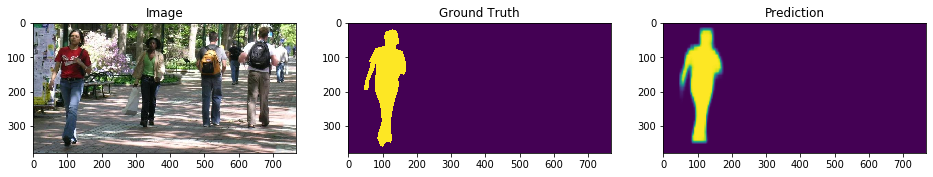

In [19]:
print(images[0].shape)
print(outputs[0]['masks'].shape)
print(targets[0]['masks'].shape)



im2display = images[0].numpy().transpose((1,2,0))
pred2display = torch.squeeze(outputs[0]['masks'][0]).detach().numpy()
gt2display = targets[0]['masks'][0].numpy()

fig, axs = plt.subplots(1, 3, figsize=(16,10))
axs[0].imshow(im2display)
axs[1].imshow(gt2display)
axs[2].imshow(pred2display)
axs[0].set_title("Image")
axs[1].set_title("Ground Truth")
axs[2].set_title("Prediction")


In [14]:
"""
Mask R-CNN
Display and Visualization Functions.
Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

#https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py

############################################################
#  Visualization
############################################################


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        if scores is not None:
            if scores[i] < .85:
                continue
        color = colors[i]
        
        #print(boxes)
        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = "Person"
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

(379, 767, 7)


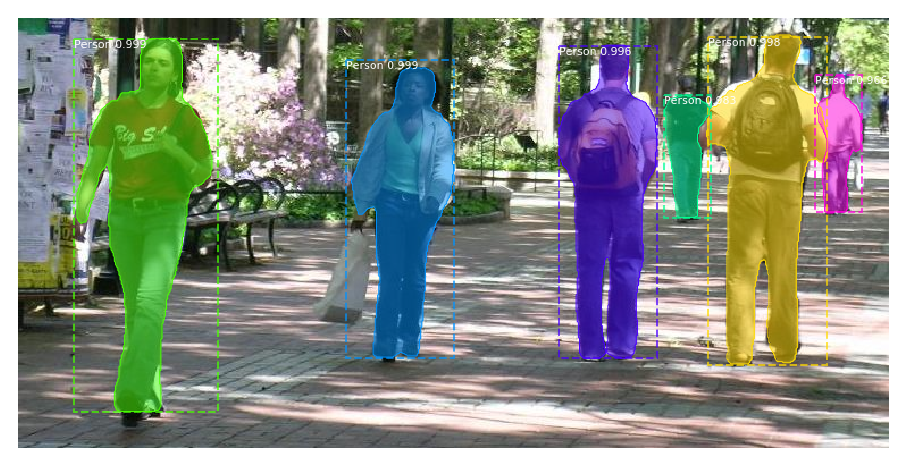

In [20]:
idx=0
#print(outputs[1]['scores'].shape)
img = images[idx].numpy().transpose((1,2,0))*255
boxes = outputs[idx]['boxes'].detach().numpy().copy()
boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3] = boxes[:,1].copy(), boxes[:,0].copy(), boxes[:,3].copy(), boxes[:,2].copy()
masks = torch.squeeze(outputs[idx]['masks']).detach().numpy().transpose(1,2,0).copy()
masks = np.where(masks>0.5, 1, 0)
print(masks.shape)
labels = outputs[idx]['labels'].detach().numpy()
scores = outputs[idx]['scores'].detach().numpy()
display_instances(img, boxes, masks, labels, scores=scores)

1


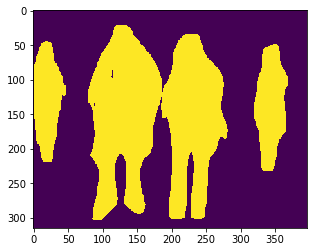

In [22]:
def binary_combined_mask(masks, scores):
    combined = np.zeros((masks.shape[0], masks.shape[1]),dtype=int)
    for N in range(masks.shape[2]):
        if scores[N] <= 0.7:
            continue
        combined[:, :] = np.where(masks[:,:,N] == 1,
                                  1,
                                  combined[:, :])
    return combined

masks = torch.squeeze(outputs[idx]['masks']).detach().numpy().transpose(1,2,0).copy()
masks = np.where(masks>0.5, 1, 0)
scores = outputs[idx]['scores'].detach().numpy()
combined = binary_combined_mask(masks, scores)
print(combined[200,100])
plt.imshow(combined)

In [46]:
coco = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:   [ 0/50]  eta: 0:00:03  model_time: 0.0466 (0.0466)  evaluator_time: 0.0079 (0.0079)  time: 0.0654  data: 0.0102  max mem: 3987
Test:   [49/50]  eta: 0:00:00  model_time: 0.0458 (0.0457)  evaluator_time: 0.0134 (0.0165)  time: 0.0861  data: 0.0239  max mem: 3987
Test:  Total time: 0:00:04 (0.0870 s / it)
Averaged stats: model_time: 0.0458 (0.0457)  evaluator_time: 0.0134 (0.0165)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.62952
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.97975
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.68053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.47472
 Average Precision  (AP) @[ IoU=0.50:0.95 | are

In [54]:
print(coco.coco_eval['bbox'].stats)
print(coco.coco_eval['segm'].stats)

[ 0.62951817  0.97975213  0.68052969 -1.          0.47472389  0.64045659
  0.29579832  0.70336134  0.70336134 -1.          0.6375      0.70810811]
[ 0.62343617  0.95899051  0.70287246 -1.          0.3031256   0.64388642
  0.30084034  0.68571429  0.68823529 -1.          0.5125      0.7009009 ]


In [59]:
metric = []
metric.append('Average_Precision/IOU=0.50:0.95_area=all_maxDets=100')
metric.append('Average_Precision/IOU=0.50_area=all_maxDets=100')
metric.append('Average_Precision/IOU=0.75_area=all_maxDets=100')
metric.append('Average_Precision/IOU=0.50:0.95_area=small_maxDets=100')
metric.append('Average_Precision/IOU=0.50:0.95_area=medium_maxDets=100')
metric.append('Average_Precision/IOU=0.50:0.95_area=large_maxDets=100')
metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=1')
metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=10')
metric.append('Average_recall/IOU=0.50:0.95_area=all_maxDets=100')
metric.append('Average_recall/IOU=0.50:0.95_area=small_maxDets=100')
metric.append('Average_recall/IOU=0.50:0.95_area=medium_maxDets=100')
metric.append('Average_recall/IOU=0.50:0.95_area=large_maxDets=100')
string = str('bbox/'+metric[0])
print(string)

bbox/Average_Precision/IOU=0.50:0.95_area=all_maxDets=100
